In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
import time
from gym.envs.registration import register
from IPython.display import clear_output
from itertools import count

In [2]:
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)

In [3]:
tf.keras.backend.set_floatx('float64')

In [4]:
env = gym.make('CartPole-v1')
print('observation_space:', env.observation_space)
print('action_space:', env.action_space)

observation_space: Box(4,)
action_space: Discrete(2)


In [5]:
class Actor():
    def __init__(self, state_dim, action_dim, lr=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.model = self.create_model()
        self.optimizer = tf.keras.optimizers.Adam(lr)
    
    def create_model(self):
        model = tf.keras.Sequential([
            tf.keras.Input((self.state_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.action_dim, activation='softmax'),
        ])
        return model
    
    def get_action_probs(self, state):
        state = tf.convert_to_tensor(state)
        state = tf.reshape(state, (-1, self.state_dim))
        action_probs = self.model(state, training=True)
        return action_probs
    
    def get_action(self, state):
        action_probs = self.get_action_probs(state)
        return tf.random.categorical(action_probs, 1)[0, 0]
        

In [6]:
class Critic():
    def __init__(self, state_dim, lr=0.001):
        self.state_dim = state_dim
        self.model = self.create_model()
        self.optimizer = tf.keras.optimizers.Adam(lr)
    
    def create_model(self):
        model = tf.keras.Sequential([
            tf.keras.Input((self.state_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='linear'),
        ])
        return model
    
    def get_value(self, state):
        state = tf.convert_to_tensor(state)
        state = tf.reshape(state, (-1, self.state_dim))
        
        value = self.model(state, training=True)
        return tf.squeeze(value, axis=1)

In [7]:
class Agent():
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        
        self.gamma = 0.99
       
    def compute_loss(self, action_probs, states, rewards, dones):
        values = self.critic.get_value(states)

        returns = []
        discounted_sum = 0
        for reward, done in zip(rewards[::-1], dones[::-1]):
            discounted_sum = reward + (1 - done) * self.gamma * discounted_sum
            returns.append(discounted_sum)
        returns = returns[::-1]

        action_log_probs = tf.math.log(action_probs)
        advantage = returns - values

        actor_loss = -tf.reduce_mean(action_log_probs * advantage)
        critic_loss = tf.keras.losses.MSE(returns, values)
        
        return actor_loss, critic_loss
        
    def run(self, num_episodes, render=False):
        ep_rewards = []
        ep_cl = []
        ep_al = []
        
        for ep in range(num_episodes):
            state = env.reset()
            
            # outputs of actor
            action_probs = []

            # outputs of environment
            states = []
            rewards = []
            dones = []

            ep_reward = 0

            with tf.GradientTape(persistent=True) as tape:

                for step in count():
                    action_probs_t = self.actor.get_action_probs(state)
                    action = np.random.choice(2, p=action_probs_t[0])

                    action_probs.append(action_probs_t[0, action])

                    states.append(state)
                    state, reward, done, _ = env.step(action)
                    if render:
                        env.render()

                    ep_reward += reward

                    rewards.append(reward)
                    dones.append(done)

                    if done:
                        break
                
                actor_loss, critic_loss = self.compute_loss(action_probs, states, rewards, dones)

            gradient = tape.gradient(actor_loss, self.actor.model.trainable_variables)
            self.actor.optimizer.apply_gradients(zip(gradient, self.actor.model.trainable_variables))

            gradient = tape.gradient(critic_loss, self.critic.model.trainable_variables)
            self.critic.optimizer.apply_gradients(zip(gradient, self.critic.model.trainable_variables))

            print("Episode: {}, total_reward: {:.2f}, actor_loss: {:.2f}, critic_loss: {:.2f}".format(ep, ep_reward, actor_loss, critic_loss))
            #clear_output(wait=True)

            ep_rewards.append(ep_reward)
            ep_al.append(actor_loss)
            ep_cl.append(critic_loss)
        
        if 1:
            import matplotlib.pyplot as plt
            %matplotlib inline
            
            avg_span = 50
            def plot(history, title):
                fig1, ax1 = plt.subplots()
                x = range(len(history))
                cumsum = np.cumsum(history)
                avgs = [cumsum[ep]/(ep+1) if ep<avg_span else (cumsum[ep]-cumsum[ep-avg_span])/avg_span for ep in x]
                ax1.plot(x, avgs, label=title)
                ax1.set_title("History")
                ax1.set_xlabel("Episode")
                ax1.set_ylabel("moving average 100")
                ax1.legend()
            
            plot(ep_rewards, 'total_reward')
            
            plot(ep_al, 'actor_loss')
            
            plot(ep_cl, 'critic_loss')
            
            
agent = Agent(env)
#agent.run(500)

In [8]:
if 0:
    agent.actor.model = tf.keras.models.load_model('ac_agent.h5', compile=False)
    agent.critic.model = tf.keras.models.load_model('ac_critic.h5', compile=False)
if 0:
    agent.actor.model.save('ac_agent.h5')
    agent.critic.model.save('ac_critic.h5')

Episode: 0, total_reward: 30.00, actor_loss: 9.82, critic_loss: 253.62
Episode: 1, total_reward: 9.00, actor_loss: 2.79, critic_loss: 29.75
Episode: 2, total_reward: 10.00, actor_loss: 2.77, critic_loss: 35.92
Episode: 3, total_reward: 10.00, actor_loss: 2.55, critic_loss: 35.56
Episode: 4, total_reward: 24.00, actor_loss: 7.51, critic_loss: 170.55
Episode: 5, total_reward: 8.00, actor_loss: 1.81, critic_loss: 23.45
Episode: 6, total_reward: 17.00, actor_loss: 4.71, critic_loss: 92.55
Episode: 7, total_reward: 10.00, actor_loss: 1.74, critic_loss: 34.72
Episode: 8, total_reward: 14.00, actor_loss: 3.68, critic_loss: 64.85
Episode: 9, total_reward: 13.00, actor_loss: 4.14, critic_loss: 56.35
Episode: 10, total_reward: 10.00, actor_loss: 1.37, critic_loss: 34.46
Episode: 11, total_reward: 20.00, actor_loss: 6.66, critic_loss: 121.95
Episode: 12, total_reward: 9.00, actor_loss: 2.35, critic_loss: 27.95
Episode: 13, total_reward: 37.00, actor_loss: 11.61, critic_loss: 361.56
Episode: 14, t

Episode: 116, total_reward: 93.00, actor_loss: 22.43, critic_loss: 1482.74
Episode: 117, total_reward: 21.00, actor_loss: 5.74, critic_loss: 116.82
Episode: 118, total_reward: 19.00, actor_loss: 5.29, critic_loss: 95.79
Episode: 119, total_reward: 14.00, actor_loss: 3.96, critic_loss: 49.83
Episode: 120, total_reward: 23.00, actor_loss: 6.38, critic_loss: 137.29
Episode: 121, total_reward: 25.00, actor_loss: 7.38, critic_loss: 161.44
Episode: 122, total_reward: 15.00, actor_loss: 4.04, critic_loss: 57.79
Episode: 123, total_reward: 19.00, actor_loss: 5.35, critic_loss: 95.74
Episode: 124, total_reward: 19.00, actor_loss: 5.15, critic_loss: 95.07
Episode: 125, total_reward: 51.00, actor_loss: 13.68, critic_loss: 574.98
Episode: 126, total_reward: 24.00, actor_loss: 6.66, critic_loss: 146.79
Episode: 127, total_reward: 13.00, actor_loss: 3.48, critic_loss: 42.40
Episode: 128, total_reward: 17.00, actor_loss: 4.49, critic_loss: 71.62
Episode: 129, total_reward: 14.00, actor_loss: 3.61, cr

Episode: 228, total_reward: 107.00, actor_loss: 20.05, critic_loss: 1628.72
Episode: 229, total_reward: 122.00, actor_loss: 23.74, critic_loss: 1948.92
Episode: 230, total_reward: 214.00, actor_loss: 32.96, critic_loss: 3693.27
Episode: 231, total_reward: 171.00, actor_loss: 29.57, critic_loss: 2943.59
Episode: 232, total_reward: 65.00, actor_loss: 14.36, critic_loss: 745.68
Episode: 233, total_reward: 117.00, actor_loss: 23.74, critic_loss: 1802.54
Episode: 234, total_reward: 273.00, actor_loss: 37.29, critic_loss: 4504.21
Episode: 235, total_reward: 85.00, actor_loss: 17.78, critic_loss: 1128.69
Episode: 236, total_reward: 150.00, actor_loss: 26.77, critic_loss: 2491.89
Episode: 237, total_reward: 102.00, actor_loss: 19.90, critic_loss: 1498.92
Episode: 238, total_reward: 73.00, actor_loss: 14.86, critic_loss: 876.64
Episode: 239, total_reward: 59.00, actor_loss: 12.24, critic_loss: 625.44
Episode: 240, total_reward: 59.00, actor_loss: 12.36, critic_loss: 610.17
Episode: 241, total_r

Episode: 339, total_reward: 500.00, actor_loss: 39.53, critic_loss: 5619.98
Episode: 340, total_reward: 15.00, actor_loss: 0.26, critic_loss: 16.43
Episode: 341, total_reward: 500.00, actor_loss: 38.05, critic_loss: 5549.73
Episode: 342, total_reward: 15.00, actor_loss: 0.64, critic_loss: 18.41
Episode: 343, total_reward: 60.00, actor_loss: 7.06, critic_loss: 477.39
Episode: 344, total_reward: 500.00, actor_loss: 39.00, critic_loss: 5448.58
Episode: 345, total_reward: 500.00, actor_loss: 38.21, critic_loss: 5437.26
Episode: 346, total_reward: 500.00, actor_loss: 37.33, critic_loss: 5451.06
Episode: 347, total_reward: 500.00, actor_loss: 35.96, critic_loss: 5472.32
Episode: 348, total_reward: 500.00, actor_loss: 39.15, critic_loss: 5392.60
Episode: 349, total_reward: 61.00, actor_loss: 7.53, critic_loss: 478.01
Episode: 350, total_reward: 500.00, actor_loss: 36.92, critic_loss: 5438.80
Episode: 351, total_reward: 500.00, actor_loss: 36.26, critic_loss: 5382.24
Episode: 352, total_reward

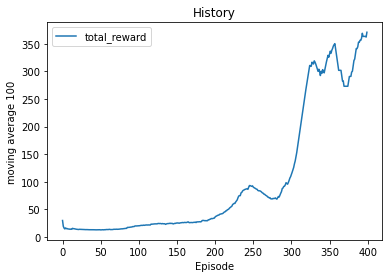

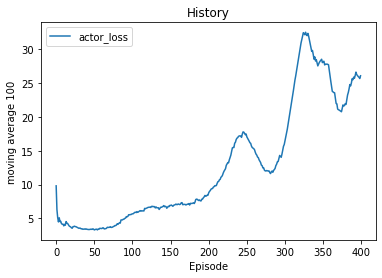

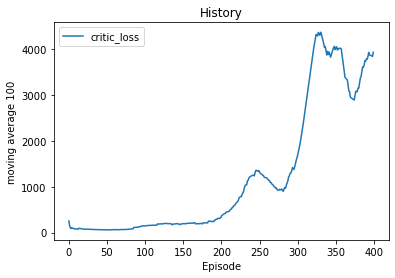

In [9]:
agent.run(400)